# The paper "Show, Attend, and Tell: Neural Image Caption Generation with Visual Attention" 

An attention based model for image caption generation.

Implementation of an extension of the paper


In [ ]:
import glob #for reading images
import matplotlib.pyplot as plt #for plotting graphs
import numpy as np
import seaborn as sns 
import pandas as pd
import matplotlib.image as mpimg

from skimage import io
pd.set_option('display.max_colwidth',None) # Set the max column width to see the complete caption

import collections #for counter
from wordcloud import WordCloud,STOPWORDS 

import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

from nltk.translate.bleu_score import sentence_bleu
import more_itertools

In [ ]:
#reading all images in Flickr8K dataset
imageFolder = 'Flickr8K/Images'
images = glob.glob(imageFolder + '/*.jpg', recursive = True)
print("No of datasets:", len(images))

No of datasets: 8091


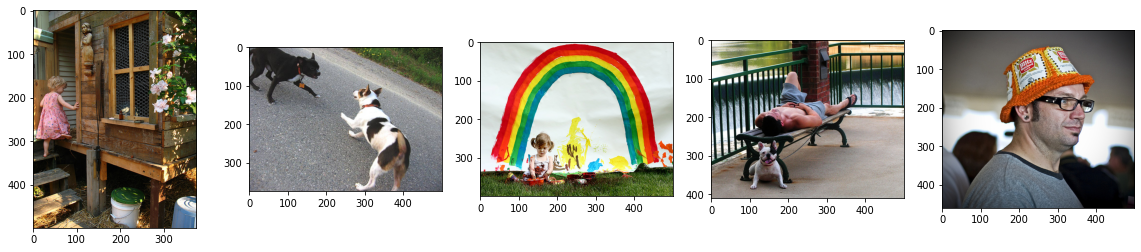

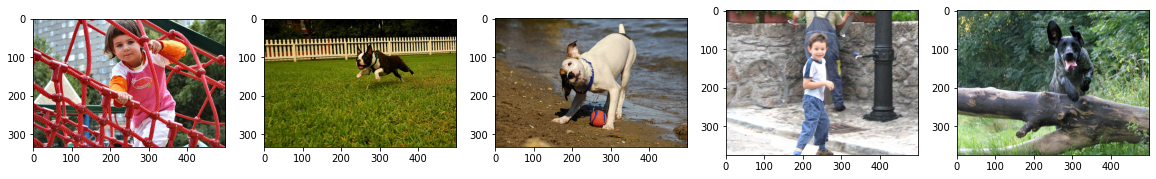

In [ ]:
#some images
displayImages= images[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, displayImages):
    ax.imshow(io.imread(image), cmap=None)

displayImages= images[5:10]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, displayImages):
    ax.imshow(io.imread(image), cmap=None)


In [ ]:
def load_doc(text_file):
    open_file = open(text_file, 'r', encoding="latin-1") 
    text = open_file.read() 
    print(text)
    open_file.close()   
    return text

In [ ]:
#read captions
textFile = 'Flickr8K/captions.txt'
doc = load_doc(textFile)
print(doc[:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#creating a dataframe with all info: imageNames, imageLocations, imageCaptions

imagePath = 'Flickr8K/Images/'
imageNames = []
imageLocations = []
imageCaptions = []

with open('Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        splitDetails=line.split(',')
        imageNames.append(splitDetails[0])
        imageCaptions.append(splitDetails[1].rstrip('\n.')) #striping \n and fullstop
        imageLocations.append(imagePath+splitDetails[0])
df = pd.DataFrame(list(zip(imageNames, imageLocations, imageCaptions)), columns = ['ID', 'Path', 'Captions'])
df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   

                                                                         Captions  
0         A child in a pink dress is climbing up a set of stairs in an entry way   
1                                            A girl going into a wooden building   
2                                 A little girl climbing into a wooden playhouse   
3                             A little girl climbing the stairs to her playhouse   
4                        A little girl in a pink dress going into a wooden cabin   
...                                                                           ...  
40450                                    A man in a pink shirt climbs a rock face  
40451                                     A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453                                              A rock climber in a red shirt   
40454                           A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [ ]:
#Some details about the dataset
print("No of captions (5*no of images) =", len(imageCaptions))

No of captions (5*no of images) = 40455


In [ ]:
#getting all the different words (these will be used in the resultant captions as well)
words = [word for line in imageCaptions for word in line.split()]
print("Words are:")
words

Words are:


['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'Two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'towa

In [ ]:
#converting to lowercase
words= [word.lower() for line in imageCaptions for word in line.split()] #We can see that we had both

wordCounts=collections.Counter(words)
wordCounts

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

In [ ]:
#words sorted by word count
for word, count in wordCounts.most_common(20):
    print(word, ": ", count)

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811


Text(0, 0.5, 'Counts')

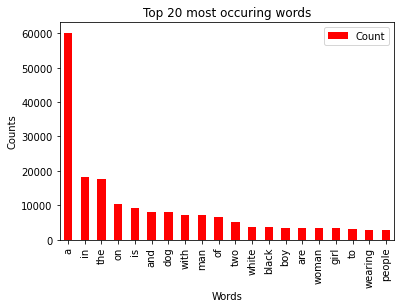

In [ ]:
#bar graph
wordCountsList = wordCounts.most_common(20) #container function
mostCommonWordsDf = pd.DataFrame(wordCountsList, columns = ['Word', 'Count'])
mostCommonWordsDf.plot.bar(x='Word',y='Count',width=0.5,color='red')
plt.title("Top 20 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

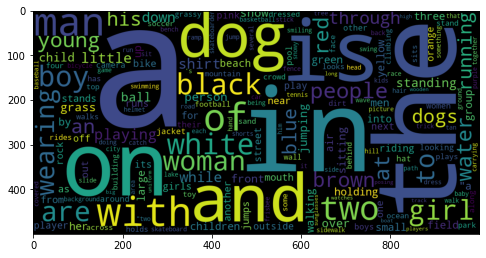

In [ ]:
#wordcloud
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(wordCounts)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735


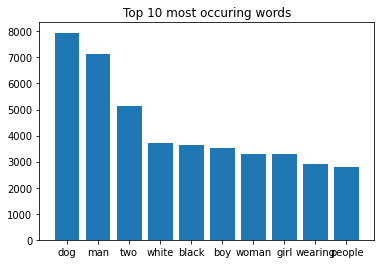

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'dog'),
  Text(1, 0, 'man'),
  Text(2, 0, 'two'),
  Text(3, 0, 'white'),
  Text(4, 0, 'black'),
  Text(5, 0, 'boy'),
  Text(6, 0, 'woman'),
  Text(7, 0, 'girl'),
  Text(8, 0, 'wearing'),
  Text(9, 0, 'people'),
  Text(10, 0, 'water'),
  Text(11, 0, 'young'),
  Text(12, 0, 'red'),
  Text(13, 0, 'brown'),
  Text(14, 0, 'blue'),
  Text(15, 0, 'dogs'),
  Text(16, 0, 'running'),
  Text(17, 0, 'playing'),
  Text(18, 0, 'little'),
  Text(19, 0, 'shirt')])

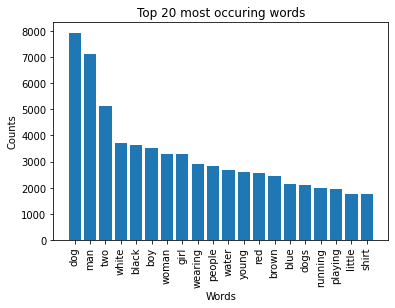

In [ ]:
#Looking at non-stopword words using frequency
sansStopWordsDict = {}
tempDict = {}
i = 0
for word, count in wordCounts.most_common(36):
    if word not in STOPWORDS:
        print(word, ": ", count)
        sansStopWordsDict[word] = count
        if i < 10:
            tempDict[word] = count
        i += 1
        
plt.title("Top 10 most occuring words")
plt.bar(*zip(*tempDict.items()))
plt.show()

plt.bar(range(len(sansStopWordsDict)), sansStopWordsDict.values(), align='center')
plt.xticks(range(len(sansStopWordsDict)), list(sansStopWordsDict.keys()))
plt.title("Top " + str(i) + " most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)

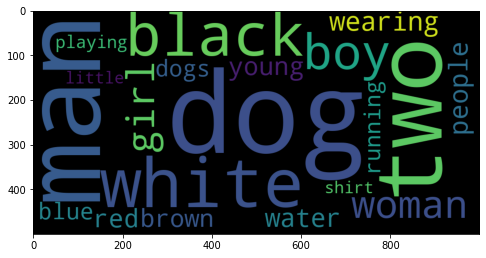

In [ ]:
#wordcloud of non-stopwords
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(sansStopWordsDict)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

Mean of caption length: 10.36576442961315


C:\Users\subha\anaconda3\envs\hello-tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


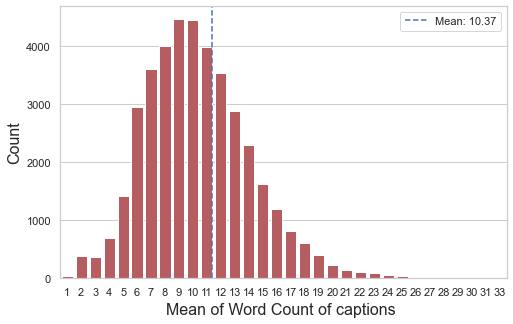

In [ ]:
#mean caption length
captionDf=df.copy()
#captionDf

captionDf['caption_word_count'] = captionDf["Captions"].str.split().str.len()
#captionDf['caption_word_count']

mean = sum(captionDf['caption_word_count'])/len(captionDf['caption_word_count'])
print("Mean of caption length:", mean)

#count of no of captions with the specified char count (x axis)
#Show the counts of observations in each categorical bin using bars

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(captionDf['caption_word_count'], color="r")
plt.xlabel('Mean of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})


Median value of caption chars: 10.0


C:\Users\subha\anaconda3\envs\hello-tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


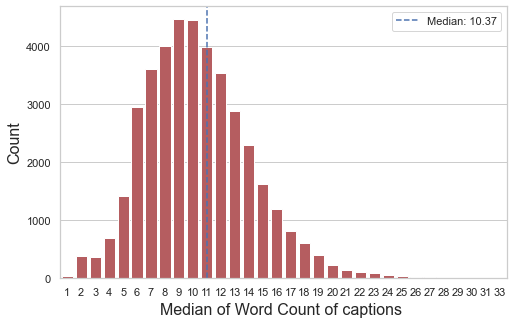

In [ ]:
median = np.median(captionDf['caption_word_count'])
print("Median value of caption chars:", median)

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(captionDf['caption_word_count'], color="r")
plt.xlabel('Median of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(median, color='b', linestyle='--')
plt.legend({'Median: {:.2f}'.format(mean): mean})



Conclusion: Most of the captions have 10 to 11 words

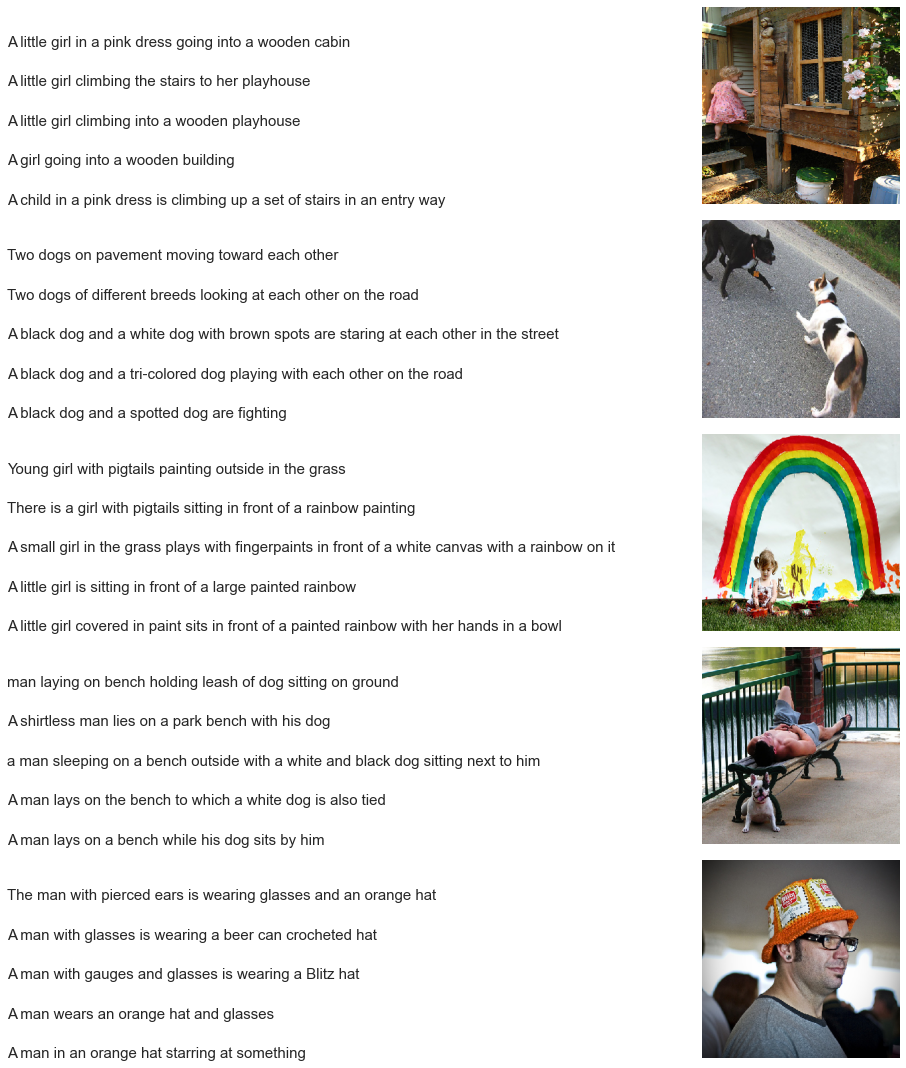

In [ ]:
#statistics of images and captions together
#Images 

fig = plt.figure(figsize=(15,15)) #for the set of 5 images
count = 1
    
for path in df[:25].Path.unique():
    captions = list(df["Captions"].loc[df.Path == path].values)
    displayImage = load_img(path, target_size=(299,299,3))
    ax = fig.add_subplot(5, 2, count) #for individual image
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap
    ax = fig.add_subplot(5,2,count)
    ax.imshow(displayImage)
    plt.axis('off')
    count +=1

plt.show()


In [ ]:
#data cleaning
#conv to lowercase
#remove punctuation
#remove numbers
#not removing stopwords but one letter words will be removed
#no stemming

In [ ]:
# Data cleaning
# returns a mapping table that can be used with the translate() method to replace specified characters
remove_punctuation = str.maketrans('', '', string.punctuation) 
for i in range(len(imageCaptions)):
    line = imageCaptions[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each word
    line = [word for word in line if len(word) > 1] # remove hanging single characters
    line = [word for word in line if word.isalpha()] # remove words with numbers in them
    imageCaptions[i]= ' '.join(line)   # store as string

In [ ]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
imageCaptions=['<start>' + ' ' +  line + ' ' + '<end>' for line in imageCaptions]

#Create a list which contains all the path to the images
all_img_path= imageLocations#write your code here

print("Total captions present in the dataset: "+ str(len(imageCaptions)))
print("Total images*5 present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images*5 present in the dataset: 40455


In [ ]:
imageCaptions[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

Pre-Processing text(captions):
1. Create tokens by removing punctuation marks, conv to lowercase, take only the top 5000 to save memory and set the rest as "UNK" for unknown words
2. Create index to word and word to index mappings
3. Pad sequences to make them all equal sized 

In [ ]:
top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ', lower=True, char_level=False, oov_token="UNK")

# Create word-to-index and index-to-word mappings
#Updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(imageCaptions)
#Transforms each text in texts to a sequence of integers
train_seqs = tokenizer.texts_to_sequences(imageCaptions)
print(train_seqs)

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3], [2, 19, 309, 63, 193, 119, 3], [2, 37, 19, 115, 63, 193, 2354, 3], [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3], [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3], [2, 15, 9, 8, 838, 9, 17, 334, 3], [2, 15, 9, 8, 1650, 9, 34, 10, 143, 92, 6, 5, 151, 3], [2, 15, 9, 8, 14, 9, 10, 27, 993, 17, 613, 23, 143, 92, 4, 5, 69, 3], [2, 13, 31, 12, 742, 2573, 90, 23, 143, 92, 6, 5, 151, 3], [2, 13, 31, 6, 719, 776, 313, 143, 92, 3], [2, 37, 19, 187, 4, 614, 103, 4, 48, 12, 576, 1334, 10, 62, 221, 4, 959, 3], [2, 37, 19, 7, 49, 4, 48, 12, 54, 576, 1334, 3], [2, 50, 19, 4, 5, 41, 111, 10, 3317, 4, 48, 12, 14, 2355, 10, 1334, 6, 154, 3], [2, 185, 7, 19, 10, 1509, 49, 4, 48, 12, 1334, 743, 3], [2, 25, 19, 10, 1509, 743, 81, 4, 5, 41, 3], [2, 11, 629, 6, 157, 35, 29, 9, 103, 56, 163, 3], [2, 11, 629, 6, 5, 157, 20, 1015, 14, 9, 7, 1440, 1573, 3], [2, 11, 606, 6, 157, 81, 10, 14, 8, 15, 9, 49, 85, 20, 163, 3], [2, 404, 11, 744, 6, 117, 157, 10

In [ ]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [ ]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [ ]:
imageCaptions[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [ ]:
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [ ]:
print("Length of sequence:", len(train_seqs))
print(type(train_seqs))

Length of sequence: 40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917


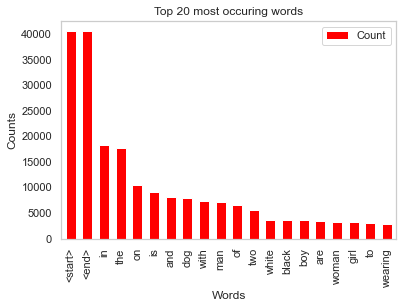

In [ ]:
# Top 20 occuring words after text processing
tokenizer_top_words= [word for line in imageCaptions for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(20):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(20)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 20 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(b=None)

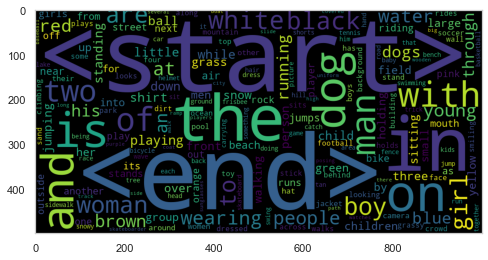

In [ ]:
#wordcount from the top frequency words
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_token)
plt.grid(b=None)

In [ ]:
train_seqs_len=[len(seq) for seq in train_seqs]
longest_word_length= max(train_seqs_len)
print("The longest word length is:", longest_word_length)

#creating caption vector with the longest word length as the size of caption - padding
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)
#padding=post because put the zeroes at the end of sequence - will cause problems while creating embedding vector so we will mask then
#Reason: 0 after <start> tag indicates no word
print("The shape of Caption vector is :" + str(cap_vector.shape))

The longest word length is: 31
The shape of Caption vector is :(40455, 31)


Pre-Processing the images:
1. Resize them into the shape of (299, 299)
2. Normalize to [-1, 1] to make it correct format for InceptionV3 (CNN by google, 48 layers deep)

In [ ]:
#checking to know about image format as we will be setting data format as none in tf.keras.applications.inception_v3.preprocess_input

tf.keras.backend.image_data_format() 

'channels_last'

Image data format have default as 'channels_last' which indicates image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

In [ ]:
IMAGE_SHAPE= (299, 299)

In [ ]:
#InceptionV3 does inbuilt preprocessing; so lets do for some images here
preprocessed_img=[]
for img in images[0:5]:
    #tensor is a generalization of vectors and matrices to potentially higher dimensions
    img = tf.io.read_file(img,name=None) #returns a tensor with contents of i/p file
    # by default channels = 0 which indicates to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image
    img = tf.image.decode_jpeg(img,channels=0) #unit8 tensor
    img = tf.image.resize(img, IMAGE_SHAPE)
    #preprocesses a tensor encoding a batch of images, format = tf.keras.backend.image_data_format()
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)
    preprocessed_img.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


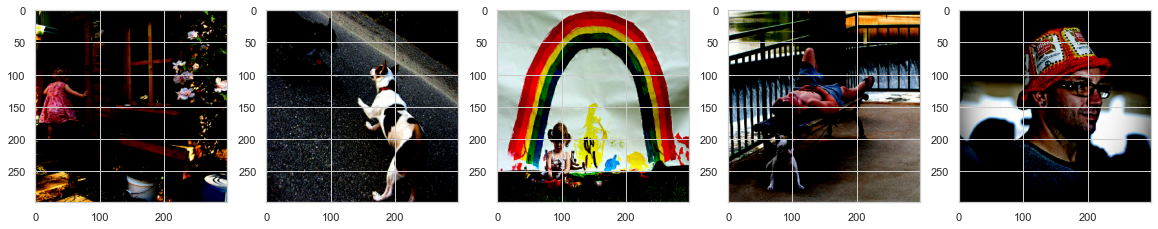

In [ ]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

In [ ]:
#Function to preprocess any image, from 2 blocks above
def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    return img, image_path

Creating test and train data
1. Combining image and captions (tf.data.Dataset API)
2. train_test_split 80:20 ratio, random state = 42
3. Shuffle and batch
4. Shape of each image: (batch_size, 299, 299, 3)
5. Shape of each caption: (batch_size, max_len)

In [ ]:
imageLocations

['Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1007129816_e794419615.jpg',
 'Flickr8K/Images/1007129816_e7944

In [ ]:
#preprocess all images
training_list = sorted(set(imageLocations))
#print(training_list)

#slicing dataset
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)
#print(New_Image_Data)

#num_parallel_calls=tf.data.experimental.AUTOTUNE - no of parallel executions = amount of cpu available
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch)
# We don't want to drop the last batch if it contains element less than 64; set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [ ]:
New_Image_Data

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

In [ ]:
# performing the train-test spliit using 80-20 ratio & random state = 42
img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(imageLocations, cap_vector, test_size=0.2, random_state=42)

In [ ]:
print("No of images in training dataset: ",len(img_train_data))
img_train_data[:5]

No of images in training dataset:  32364


['Flickr8K/Images/359082432_c1fd5aa2d6.jpg',
 'Flickr8K/Images/2460799229_ce45a1d940.jpg',
 'Flickr8K/Images/3634828052_3b6aeda7d6.jpg',
 'Flickr8K/Images/2216568822_84c295c3b0.jpg',
 'Flickr8K/Images/3080056515_3013830309.jpg']

In [ ]:
print("No of images in testing dataset: ",len(img_test_data))
img_test_data[0:5]

No of images in testing dataset:  8091


['Flickr8K/Images/2973269132_252bfd0160.jpg',
 'Flickr8K/Images/270263570_3160f360d3.jpg',
 'Flickr8K/Images/2053006423_6adf69ca67.jpg',
 'Flickr8K/Images/512101751_05a6d93e19.jpg',
 'Flickr8K/Images/3156406419_38fbd52007.jpg']

In [ ]:
print("No of captions in training dataset: ",len(caption_train_data))
caption_train_data[0:5]

No of captions in training dataset:  32364


array([[   2,   11,    8,    9,   17,   39,    6,  146,  148,  110,  542,
          46,   20,    5,  170,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    5,   47,   95,  238,   17,   21,  472,  543,   17,   90,
          63,    5,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   94,   10,  283,  195, 2640,  278,  140,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   26, 2236,  168,    8, 1869,  455, 1056,    6,
          62,  325,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   80,   42,    7, 3255,   20,   72,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [ ]:
print("No of captions in testing dataset: ",len(caption_test_data))
caption_test_data[0:5]

No of captions in testing dataset:  8091


array([[   2,   54, 1626,  588,    7, 4556,  223,  121, 1476,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   13,   27,   31,  500,    6,    5, 1681,  170,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   11,    4,  164,    7,   39,    6,   82,   90,   87,   23,
           5,  458,   74,    5, 3975,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  887,   14,    9,    7,   32,    6,    5,   41,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   42,  376,  727,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

Step 1: CNN
1. Load pretrained Imagenet weights of Inception net V3 - saves RAM
2. Use last layer of pre-trained model(V3) to train (8*8*2048)
3. Extract features from test and train dataset of size (batch_size, 8*8. 2048)


In [ ]:
#returns a Keras image classification model loaded with weights pre-trained on ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
#get i/p and o/p 
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
#build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Remove softmax layer(used for classification) and get the image vector.
# extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    features_for_batch_flattened = tf.reshape(features_for_batch, (features_for_batch.shape[0], -1, features_for_batch.shape[3]))                               
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [07:56<00:00,  3.75s/it]


In [ ]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.74665326e-02, 0.00000000e+00, ...,
          2.31837019e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07787609e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94032162e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85755104e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42666084e-02, 0.00000000e+00, 5.05790770e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23005015e-01, 1.34471357e-02, ...,
          2.33669803e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [ ]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.00000000e+00, 7.74665326e-02, 0.00000000e+00, ...,
         2.31837019e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.07787609e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.94032162e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.85755104e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.65693688e+00, 0.00000000e+00],
        [0.00000000e+00, 4.02608901e-01, 0.00000000e+00, ...,
         0.00000000e+00, 3.17919135e-01, 0.00000000e+00],
        [0.00000000e+00, 2.53475714e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.25060153e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.84972608e-02, ...,
         1.20641959e+00, 0.

In [ ]:
len(image_features_dict)

8091

In [ ]:
image_features_dict

{'Flickr8K/Images/1000268201_693b08cb0e.jpg': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.16987158],
        [0.        , 0.        , 1.0105941 , ..., 0.        , 0.        ,
         0.06111852],
        ...,
        [0.        , 0.        , 2.038044  , ..., 1.2029713 , 0.        ,
         1.9924142 ],
        [0.        , 0.        , 0.90469027, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.2527303 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 'Flickr8K/Images/1001773457_577c3a7d70.jpg': array([[0.        , 0.66368175, 0.46285966, ..., 0.        , 0.        ,
         3.3322608 ],
        [0.        , 1.2268165 , 0.        , ..., 0.        , 0.253902  ,
         3.3295352 ],
        [1.2881926 , 1.519541  , 0.        , ..., 0.4677789 , 0.36474568,
         3.8172603 ],
        ...,
   

In [ ]:
batch_feat.shape

TensorShape([64, 2048])

In [ ]:
top_5_items = more_itertools.take(5, image_features_dict.items()) #return first n items of the iterable as a list
top_5_items #printing first 5 elememts have dictionary

[('Flickr8K/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16987158],
         [0.        , 0.        , 1.0105941 , ..., 0.        , 0.        ,
          0.06111852],
         ...,
         [0.        , 0.        , 2.038044  , ..., 1.2029713 , 0.        ,
          1.9924142 ],
         [0.        , 0.        , 0.90469027, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527303 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('Flickr8K/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66368175, 0.46285966, ..., 0.        , 0.        ,
          3.3322608 ],
         [0.        , 1.2268165 , 0.        , ..., 0.        , 0.253902  ,
          3.3295352 ],
         [1.2881926 , 1.519541  , 0.        , ..., 0.4677789 , 0.36474568,
          3.817

In [ ]:
#model i/p: feature, caption
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')] #feature of image from dict
    return image_final,captions

In [ ]:
#batching and shuffling
#always shuffle before batching
#tensorflow could not shuffle the whole dataset so we make it shuffle buffer sizes
BUFFER_SIZE = 1000
#Batch size - should be 2**x for good measure
BATCH_SIZE = 128
def data_generator(images_data, captions_data):  
    #Create a Dataset whose elements are slices of the given tensors
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    #the number of parallel calls is set dynamically based on available CPU, saves time
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    #Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    #We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    #Prefetch function is used to prepare later elements while the current element is being processed.
    dataset = (dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)) 
    return dataset

In [ ]:
train_dataset=data_generator(img_train_data,caption_train_data) 
test_dataset=data_generator(img_test_data,caption_test_data) 

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size, 31)

(128, 64, 2048)
(128, 31)


Model Building:
1. Set parameters
2. Build the encoder, attention model & decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE
max_length = 31
features_shape = batch_feat.shape[1] #64
attention_features_shape = batch_feat.shape[0] #2048

Encoder

In [ ]:
#Clears the default graph stack and resets the global default graph - to resolve compatibility issue
tf.compat.v1.reset_default_graph()

In [ ]:
print(tf.compat.v1.get_default_graph())

In [ ]:
class Encoder(Model):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        #The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero
        #alpha -> governs the slope for values lower than the threshold - use a non-zero multiple of the input for values below the threshold
        #max_value -> sets the the largest value the function will return
        #threshold -> the threshold value of the activation function below which values will be damped or set to zero.
        return features

In [ ]:
encoder=Encoder(embedding_dim)

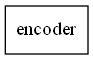

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#Dense layer
        self.W2 = tf.keras.layers.Dense(units) #Dense layer
        self.V = tf.keras.layers.Dense(1)#final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        #hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score function to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') #Gated Recurrent Unit
        #units - dimensionality of the output space
        #return_sequences - not the last output in the output sequence, return the full sequence
        #return_state - return the last state in addition to the output
        #recurrent_initializer - used for the linear transformation of the recurrent state. Default: orthogonal
        #Draws samples from a uniform distribution within [-limit, limit] 
        #limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units)
        
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) #embed input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) #Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) #Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size) -1 => remove the dimension
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Final output: vocab_size because we need to assign probability for every word in vocabulary

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (128, 64, 256)
Predictions shape from Decoder: (128, 5001)
Attention weights shape from Decoder: (128, 64, 1)


Model training & optimization:
1. Set optimizer and loss object
2. Create checkpoint path
3. Create training and testing step functions
4. Create loss function for test dataset


In [ ]:
#Step 1:
#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments, alternative to gradient descent
optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
#Computes the crossentropy loss between the labels and predictions.
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object
#we always need to choose appropriate loss function.Let us use crossentropy SparseCategoricalCrossentropy.
# It calculates loss between the labels and predictions.

In [ ]:
#the prev introduced 0s need to be masked because we dont want decoder to give importance to zero
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #Returns the truth value of NOT x element-wise
    loss_ = loss_object(real, pred) #labels, predictions
    mask = tf.cast(mask, dtype=loss_.dtype) #Casts a tensor to a new type
    loss_ *= mask # we are multiplying loss with mask to get ideal shape
    return tf.reduce_mean(loss_) #Computes the mean of elements across dimensions of a tensor

In [ ]:
#step 2:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint: #Find the filename of latest saved checkpoint file
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
#Compiles a function into a callable TensorFlow graph
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    #Returns a tensor with a length 1 axis inserted at index axis(here 1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    #Record operations for automatic differentiation for implementing backpropagation - calculates the gradient of the error function with respect to the neural network's weights
    with tf.GradientTape() as tape: #Record operations for automatic differentiation
        encoder_output = encoder(img_tensor)
        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
          loss += loss_function(target[:, t], predictions) #loss for batch
          dec_input = tf.expand_dims(target[:, t], 1) #decoder input
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables #Returns all variables created with trainable=True.
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable
    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))     
    return loss, avg_loss

In [ ]:
#same but for testing
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        encoder_output = encoder(img_tensor)
        for t in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
          loss += loss_function(target[:, t], predictions) 
          # using teacher forcing - target word is passed as the next input to the decoder
          dec_input = tf.expand_dims(target[:, t], 1)
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable
    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
    return loss, avg_loss

In [ ]:
#get loss on test data
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)): #progress bar
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|█████▎                                                                          | 1/15 [11:22<2:39:19, 682.79s/it]

For epoch: 1, the train loss is 1.560, & test loss is 1.288
Time taken for 1 epoch 682.6175239086151 sec

Test loss has been reduced from 100.000 to 1.288


 13%|██████████▋                                                                     | 2/15 [21:04<2:15:03, 623.36s/it]

For epoch: 2, the train loss is 1.175, & test loss is 1.123
Time taken for 1 epoch 581.5901782512665 sec

Test loss has been reduced from 1.288 to 1.123


 20%|████████████████                                                                | 3/15 [32:42<2:11:26, 657.22s/it]

For epoch: 3, the train loss is 1.059, & test loss is 1.026
Time taken for 1 epoch 697.3503911495209 sec

Test loss has been reduced from 1.123 to 1.026


 27%|█████████████████████▎                                                          | 4/15 [45:32<2:08:41, 701.99s/it]

For epoch: 4, the train loss is 0.982, & test loss is 0.960
Time taken for 1 epoch 770.4542305469513 sec

Test loss has been reduced from 1.026 to 0.960


 33%|██████████████████████████▋                                                     | 5/15 [58:56<2:03:08, 738.83s/it]

For epoch: 5, the train loss is 0.921, & test loss is 0.902
Time taken for 1 epoch 803.9868686199188 sec

Test loss has been reduced from 0.960 to 0.902


 40%|███████████████████████████████▏                                              | 6/15 [1:12:26<1:54:27, 763.01s/it]

For epoch: 6, the train loss is 0.871, & test loss is 0.852
Time taken for 1 epoch 809.7707357406616 sec

Test loss has been reduced from 0.902 to 0.852


 47%|████████████████████████████████████▍                                         | 7/15 [1:25:44<1:43:15, 774.43s/it]

For epoch: 7, the train loss is 0.826, & test loss is 0.809
Time taken for 1 epoch 797.7512722015381 sec

Test loss has been reduced from 0.852 to 0.809


 53%|█████████████████████████████████████████▌                                    | 8/15 [1:39:07<1:31:24, 783.46s/it]

For epoch: 8, the train loss is 0.785, & test loss is 0.766
Time taken for 1 epoch 802.6320760250092 sec

Test loss has been reduced from 0.809 to 0.766
For epoch: 9, the train loss is 0.746, & test loss is 0.731
Time taken for 1 epoch 830.4263999462128 sec

Test loss has been reduced from 0.766 to 0.731


 60%|██████████████████████████████████████████████▊                               | 9/15 [1:52:58<1:19:49, 798.21s/it]

For epoch: 10, the train loss is 0.711, & test loss is 0.695
Time taken for 1 epoch 893.5444176197052 sec

Test loss has been reduced from 0.731 to 0.695


 73%|█████████████████████████████████████████████████████████▉                     | 11/15 [2:21:54<55:28, 832.16s/it]

For epoch: 11, the train loss is 0.678, & test loss is 0.660
Time taken for 1 epoch 842.0906774997711 sec

Test loss has been reduced from 0.695 to 0.660


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [2:35:01<40:55, 818.41s/it]

For epoch: 12, the train loss is 0.647, & test loss is 0.634
Time taken for 1 epoch 786.8104968070984 sec

Test loss has been reduced from 0.660 to 0.634


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [2:48:13<27:00, 810.48s/it]

For epoch: 13, the train loss is 0.617, & test loss is 0.601
Time taken for 1 epoch 792.0189068317413 sec

Test loss has been reduced from 0.634 to 0.601


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [3:01:11<13:20, 800.75s/it]

For epoch: 14, the train loss is 0.590, & test loss is 0.581
Time taken for 1 epoch 778.1178154945374 sec

Test loss has been reduced from 0.601 to 0.581


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [3:14:28<00:00, 777.88s/it]

For epoch: 15, the train loss is 0.567, & test loss is 0.556
Time taken for 1 epoch 796.3547427654266 sec

Test loss has been reduced from 0.581 to 0.556


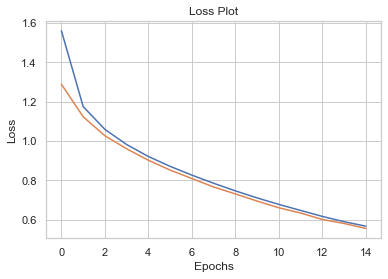

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()

Model Evaluation:
1. Define evaluation function using greedy search
2. Test it on a sample data using BLEU score


In [ ]:
#greedy search
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0)
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)
    #get value to send to decoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        #extract the predicted id(embedded value) which carries the max value
        predicted_id =  tf.argmax(predictions[0]).numpy()
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])
        #end of a caption/"token"
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def plot_attmap(caption, weights, image):
    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS)) #for image scaling
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        img=ax.imshow(temp_img)
        #The Colormap instance or registered colormap name used to map scalar data to colors. This parameter is ignored for RGB(A) data.
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent()) #here shades of read
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2) # the amount of height and width reserved for space between subplots,
    plt.show()

In [ ]:
#filtering <start>, <end> and <unk> (because we conv to lowercase)
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
img_test=img_test_data.copy()

In [ ]:
#modifying the given code as function to run it several times by changing weights
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):
    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Let's use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

C:\Users\subha\anaconda3\envs\hello-tf\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 44.77118844014734
Real Caption: large wild cat is pursuing horse across meadow
Prediction Caption: the dirty dog is pursuing horse pursuing animal


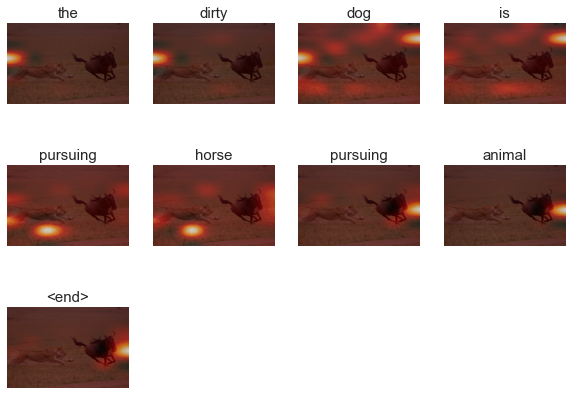

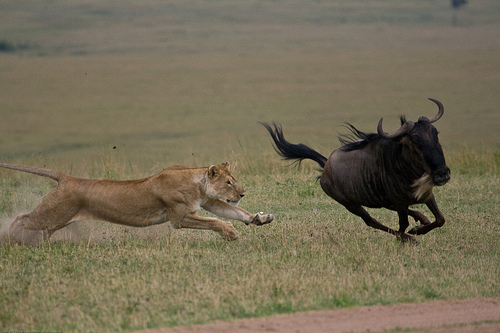

In [ ]:
test_image=predicted_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

In [ ]:
#test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

#Image.open(test_image)

C:\Users\subha\anaconda3\envs\hello-tf\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 2.446225477056264e-76
Real Caption: skateboarder performs skateboard trick against graffiti wall
Prediction Caption: skateboarder grinding lip


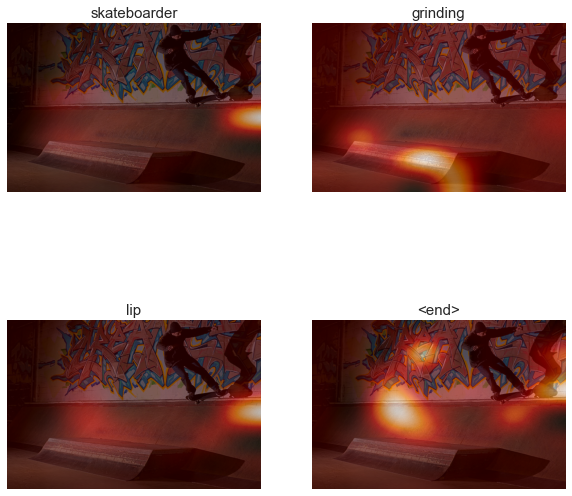

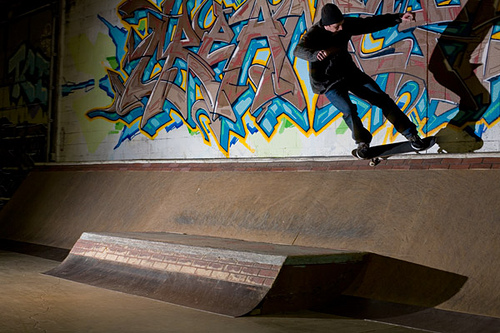

In [ ]:
test_image1=predicted_caption_audio(len(img_test),False,weights=(0.25,0.25,0,0))

Image.open(test_image1)

C:\Users\subha\anaconda3\envs\hello-tf\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 27.30248242133568
Real Caption: young man wearing green and white shirt hanging by two straps in subway car
Prediction Caption: boy in green shirt playing in subway car


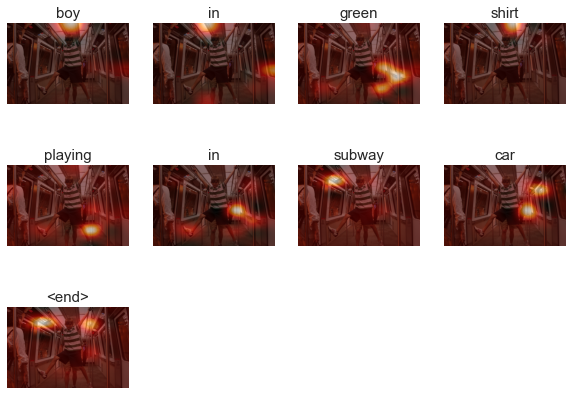

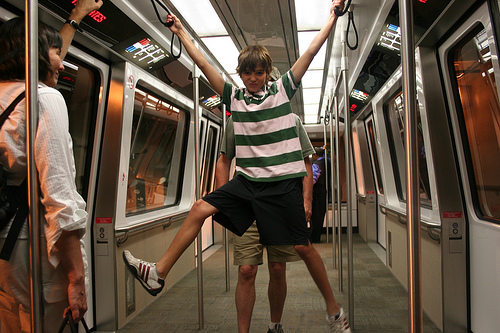

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 0
Real Caption: smiling woman punching dog
Prediction Caption: the two people are playing on the sidewalk


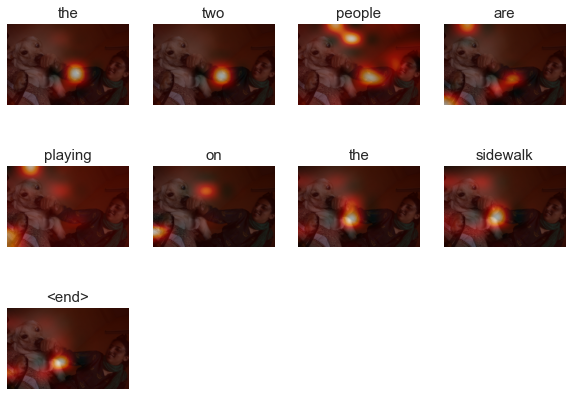

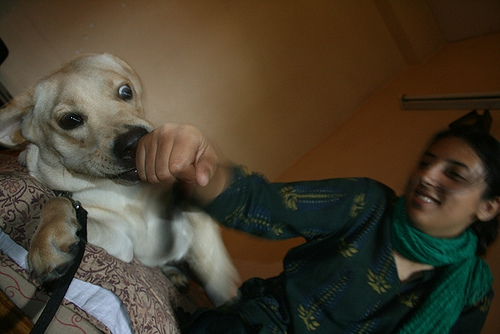

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)

BELU score: 0
Real Caption: couple are holding hands next to very large mirror outdoors
Prediction Caption: man in red shirt and sunglasses on busy street


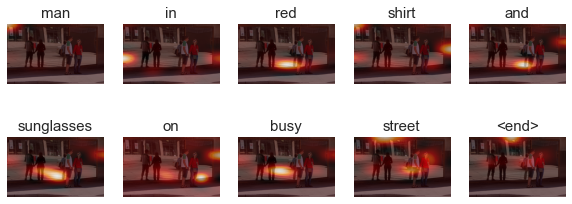

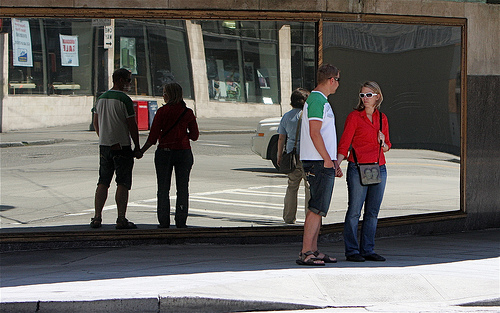

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)